In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget --no-check-certificate \
    -r 'https://docs.google.com/uc?export=download&id=16XvPBgm0_ImeB3TmudnV0c2JTMc074wK' \
    -O /content/dataset_gray_split.zip

will be placed in the single file you specified.

--2021-11-29 00:22:39--  https://docs.google.com/uc?export=download&id=16XvPBgm0_ImeB3TmudnV0c2JTMc074wK
Resolving docs.google.com (docs.google.com)... 142.250.103.102, 142.250.103.113, 142.250.103.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d5ghilldnaads9q1qpre1dma16mvtt20/1638145350000/05754306046710977403/*/16XvPBgm0_ImeB3TmudnV0c2JTMc074wK?e=download [following]
--2021-11-29 00:22:50--  https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d5ghilldnaads9q1qpre1dma16mvtt20/1638145350000/05754306046710977403/*/16XvPBgm0_ImeB3TmudnV0c2JTMc074wK?e=download
Resolving doc-0k-9s-docs.googleusercontent.com (doc-0k-9s-docs.googleusercontent.com)... 74.125.202.132, 2607:f8b0:4001:c06::84
Connectin

In [ ]:
import os
import zipfile

local_zip = '/content/dataset_gray_split.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset_gray_split/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


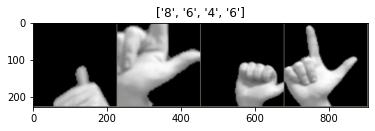

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    loss_list = {}
    loss_list['train'] = []
    loss_list['test'] = []

    accuracy_list = {}
    accuracy_list['train'] = []
    accuracy_list['test'] = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_list[phase].append(epoch_loss)
            accuracy_list[phase].append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_list, accuracy_list

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('real: {} predicted: {}'.format(labels[j],class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
epochs = 15
model_ft, loss_resnet, accuracy_resnet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8134 Acc: 0.7333
test Loss: 0.0235 Acc: 0.9941

Epoch 1/14
----------
train Loss: 0.4690 Acc: 0.8430
test Loss: 0.0052 Acc: 0.9993

Epoch 2/14
----------
train Loss: 0.3785 Acc: 0.8762
test Loss: 0.0027 Acc: 1.0000

Epoch 3/14
----------
train Loss: 0.3453 Acc: 0.8848
test Loss: 0.0017 Acc: 1.0000

Epoch 4/14
----------
train Loss: 0.3085 Acc: 0.8956
test Loss: 0.0022 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.2764 Acc: 0.9045
test Loss: 0.0005 Acc: 1.0000

Epoch 6/14
----------
train Loss: 0.2645 Acc: 0.9088
test Loss: 0.0003 Acc: 1.0000

Epoch 7/14
----------
train Loss: 0.2284 Acc: 0.9177
test Loss: 0.0005 Acc: 1.0000

Epoch 8/14
----------
train Loss: 0.2057 Acc: 0.9286
test Loss: 0.0005 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.2253 Acc: 0.9205
test Loss: 0.0002 Acc: 1.0000

Epoch 10/14
----------
train Loss: 0.2003 Acc: 0.9307
test Loss: 0.0002 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.2090 Acc: 0.9229
test Loss: 0.0002 Acc: 1.0000

Epoch 12/14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


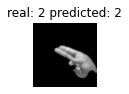

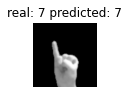

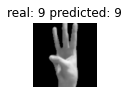

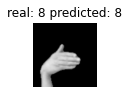

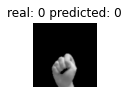

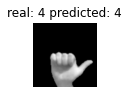

In [ ]:
visualize_model(model_ft)

In [ ]:
print(len(dataloaders['train'].dataset))

5381


In [ ]:
print(len(dataloaders['test'].dataset))

1346


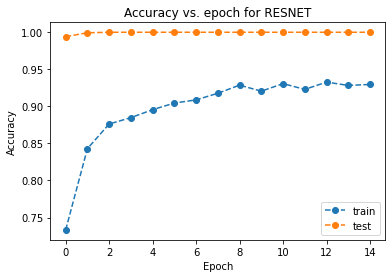

In [ ]:
plt.plot(list(range(epochs)), accuracy_resnet["train"], marker="o", linestyle='--', label ="train")
plt.plot(list(range(epochs)), accuracy_resnet["test"], marker="o", linestyle='--', label ="test")
plt.title("Accuracy vs. epoch for RESNET")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best');

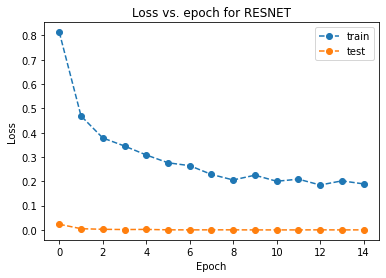

In [ ]:
plt.plot(list(range(epochs)), loss_resnet["train"], marker="o", linestyle='--', label ="train")
plt.plot(list(range(epochs)), loss_resnet["test"], marker="o", linestyle='--', label ="test")
plt.title("Loss vs. epoch for RESNET")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best');

In [ ]:
from prettytable import PrettyTable
from torchvision import datasets, models, transforms

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = models.alexnet()
count_parameters(model)

#Reference:
#https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|  features.0.weight  |   23232    |
|   features.0.bias   |     64     |
|  features.3.weight  |   307200   |
|   features.3.bias   |    192     |
|  features.6.weight  |   663552   |
|   features.6.bias   |    384     |
|  features.8.weight  |   884736   |
|   features.8.bias   |    256     |
|  features.10.weight |   589824   |
|   features.10.bias  |    256     |
| classifier.1.weight |  37748736  |
|  classifier.1.bias  |    4096    |
| classifier.4.weight |  16777216  |
|  classifier.4.bias  |    4096    |
| classifier.6.weight |  4096000   |
|  classifier.6.bias  |    1000    |
+---------------------+------------+
Total Trainable Params: 61100840


61100840

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

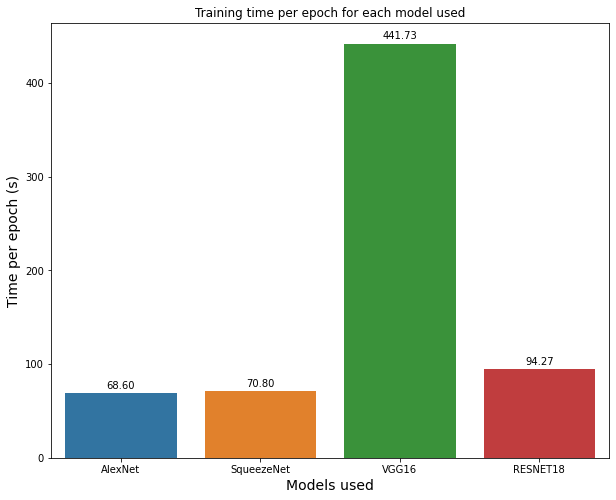

[68.6, 70.8, 441.73333333333335, 94.26666666666667]

In [ ]:
models_used = ["AlexNet","SqueezeNet","VGG16","RESNET18"]
time_per_epoch = [(17*60+9)/15,(17*60+42)/15,(110*60+26)/15,(23*60+34)/15]

data = {"Model": models_used, "Time per epoch": time_per_epoch}
df = pd.DataFrame(data, columns=['Model', 'Time per epoch'])

plt.figure(figsize=(10, 8))
plots = sns.barplot(x="Model", y="Time per epoch", data=df)

for bar in plots.patches:
  plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
plt.xlabel("Models used", size=14)
plt.ylabel("Time per epoch (s)", size=14)
plt.title("Training time per epoch for each model used")
plt.show()
time_per_epoch

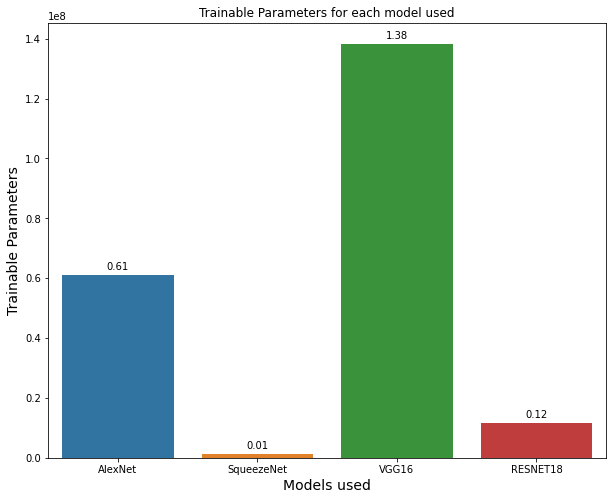

In [ ]:
models_used = ["AlexNet","SqueezeNet","VGG16","RESNET18"]
trainable_params = [61100840,1248424,138357544,11689512]

data = {"Model": models_used, "Trainable Params": trainable_params}
df = pd.DataFrame(data, columns=['Model', 'Trainable Params'])

plt.figure(figsize=(10, 8))
plots = sns.barplot(x="Model", y="Trainable Params", data=df)

for bar in plots.patches:
  plots.annotate(format(bar.get_height()/10**8, '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
plt.xlabel("Models used", size=14)
plt.ylabel("Trainable Parameters", size=14)
plt.title("Trainable Parameters for each model used")
plt.show()

In [ ]:
5381/(5381+1346)

0.7999108071948863